In [1]:
import numpy as np

from obspy import read, UTCDateTime

from obspy import Trace
import os
from collections import defaultdict
import itertools
from datetime import datetime, timedelta


import pandas as pd
from tqdm.auto import tqdm
from icecream import ic


import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import colormaps

import plotly.express as px
import plotly.graph_objects as go
import csv

import warnings
warnings.filterwarnings("ignore")


### Funciones para encontrar los archivos de los sismos

In [2]:
# entrega de vuelta un diccionario con la extensión del archivo como llave, y el path a cada archivo como valor
def find_files(path, extensions):
    file_list = {ext: [] for ext in list(extensions)}
    for root, dirs, files in os.walk(path):
        for file in files:
            for ext in extensions:
                if file.endswith(ext):
                    file_list[ext].append(os.path.join(root, file))

    return file_list

# Junta los archivos por carpeta y canal. Queda un diccionario que tiene como llave la carpeta y el canal, 
# y como valor una lista con los paths a los archivos de esa carpeta y canal.
def sort_files(file_dic, extension):
    # Diccionario para almacenar los archivos por carpeta y canal
    grouped_files = defaultdict(list)
    key_names = []
    for file in file_dic[extension]:
        # Extraer la carpeta y el canal del path del archivo
        parts = file.split("\\")
        folder = parts[-2]  # La carpeta es el penúltimo elemento en el path
        channel = parts[-1].split('_')[0]  # El canal es el primer elemento en el nombre del archivo
        key = folder + "\\" + channel
        if [key] not in key_names:
            key_names.append([key])
        # Agrupar los archivos
        grouped_files[key].append(file)

    key_names = list(itertools.chain(*key_names))
    return grouped_files, key_names

### Testear predicción con respecto a archivo times_events_24hrs.txt en su primera columna

In [3]:
# Función para leer tiempos de un archivo
def read_times(filename, time_format, skip_header=True):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        if skip_header:
            next(reader)  # Saltar la cabecera
        return [datetime.strptime(row[0], time_format) for row in reader]

# Leer tiempos reales y predichos
tiempos_reales = read_times('times_events_24hrs_sup30.txt', '%Y-%m-%dT%H:%M:%S')
tiempos_predichos = read_times('time_trigger.txt', '%Y-%m-%dT%H:%M:%S.%fZ', skip_header=False)

# Crear conjuntos con tiempos reales y predichos sin segundos
conjunto_reales = set([t.replace(second=0) for t in tiempos_reales])
conjunto_predichos = set([t.replace(second=0, microsecond=0) for t in tiempos_predichos])

# Calcular verdaderos positivos, falsos positivos y falsos negativos
verdaderos_positivos = conjunto_reales & conjunto_predichos
falsos_positivos = conjunto_predichos - conjunto_reales
falsos_negativos = conjunto_reales - conjunto_predichos

resultados = {'Verdaderos Positivos': len(verdaderos_positivos),
              'Falsos Positivos': len(falsos_positivos),
              'Falsos Negativos': len(falsos_negativos)}

# Crear diccionarios para mapear cada tiempo a su segundo correspondiente
dict_tiempos_reales = {t.replace(second=0): t.second for t in tiempos_reales}
dict_tiempos_predichos = {t.replace(second=0, microsecond=0): t.second for t in tiempos_predichos}

# Esto siguiente es para poder tener los tiempos con los segundos, y no solo las horas y minutos
v_positivos = sorted([t.replace(second=dict_tiempos_predichos[t]) for t in verdaderos_positivos])
f_positivos = sorted([t.replace(second=dict_tiempos_predichos[t]) for t in falsos_positivos])
f_negativos = sorted([t.replace(second=dict_tiempos_reales[t]) for t in falsos_negativos])


# Leer magnitudes de un archivo
with open('times_events_24hrs_sup30.txt', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Saltar la cabecera
    magnitudes = {datetime.strptime(row[0], '%Y-%m-%dT%H:%M:%S'): float(row[1]) for row in reader}

# Mapear cada verdadero positivo a su magnitud correspondiente
# Mapear cada verdadero positivo a su magnitud correspondiente usando los tiempos reales
t_real_v_positivos = sorted([datetime(t.year, t.month, t.day, t.hour, t.minute, dict_tiempos_reales[t]) for t in verdaderos_positivos])
t_real_v_positivos = [datetime.strptime(t.isoformat(), '%Y-%m-%dT%H:%M:%S') for t in t_real_v_positivos]
magnitudes_verdaderos_positivos = {t: magnitudes[t] for t in t_real_v_positivos}



In [47]:
# Leer magnitudes
magnitudes_real = []
with open('times_events_24hrs_sup30.txt', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        magnitudes_real.append(float(row['Magnitud']))

# Utilizar una paleta de colores
cmap = sns.color_palette("viridis", as_cmap=True)

# Crear un objeto de figura de Plotly
fig_magnitud = go.Figure()

# Agregar la traza de dispersión al objeto de figura
fig_magnitud.add_trace(go.Scatter(
    x=tiempos_reales,
    y=magnitudes_real,
    mode='markers',
    name='Magnitudes',
    marker=dict(
        color=magnitudes_real,
        colorscale='Jet',
        size=10,
        colorbar=dict(
            title='Magnitud',
        )
    )
))

# Personalizar diseño
fig_magnitud.update_layout(
    title='Magnitudes de los eventos sísmicos catalogados superiores a 3.0',
    xaxis_title='Tiempo Real',
    xaxis=dict(
        tickformat='%Y-%m-%d %H:%M:%S',
        tickangle=-45,
        type='date'
    ),
    yaxis_title='Magnitud',
    font=dict(family="Arial", size=12, color="white"),
    height=600,  # Ajustar la altura del gráfico
    width=1300,    # Ajustar el ancho del gráfico
    paper_bgcolor='dimgray',      # Cambiar el color de fondo del gráfico
    plot_bgcolor='dimgray',       # Cambiar el color de fondo de la trama
    title_font=dict(size=20, color="white")  # Ajustar el tamaño y color del título
)

# Mostrar gráfico interactivo
fig_magnitud.show()

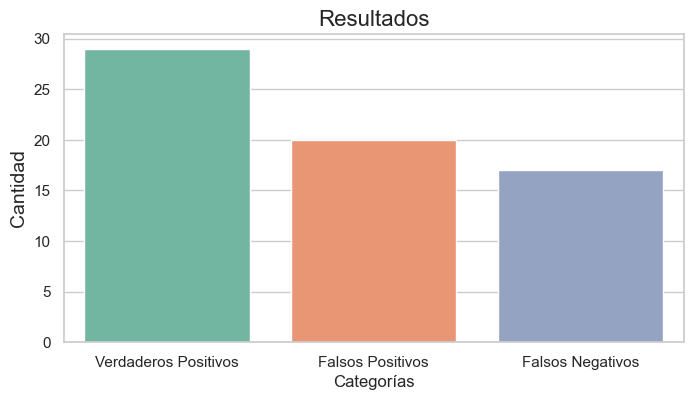

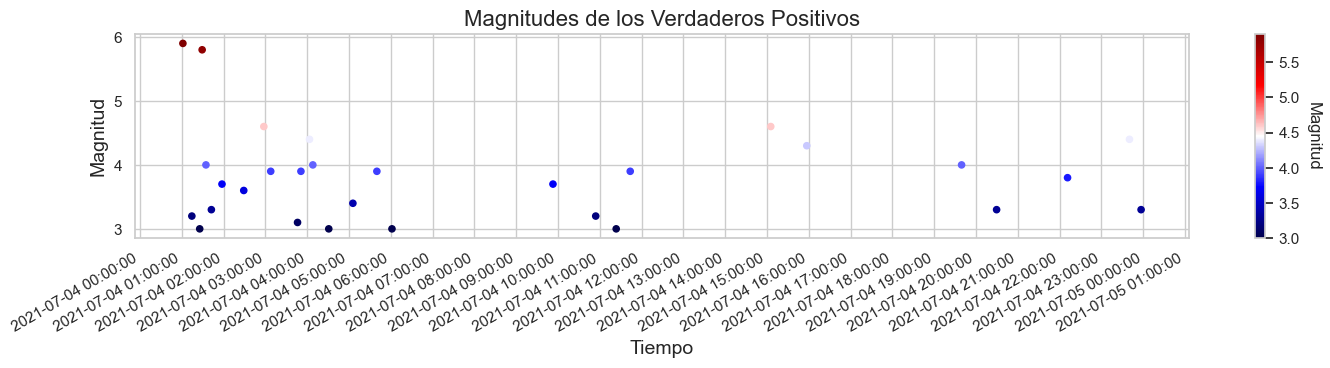

In [52]:
# Configurar el estilo de los gráficos
sns.set_theme(style="whitegrid")

# Graficar los resultados con colores variados
colores_resultados = sns.color_palette("Set2", n_colors=len(resultados))

plt.figure(figsize=(8, 4))
sns.barplot(x=list(resultados.keys()), y=list(resultados.values()), palette=colores_resultados)
plt.xlabel('Categorías', fontsize=12)
plt.ylabel('Cantidad', fontsize=14)
plt.title('Resultados', fontsize=16)
plt.show()



# Graficar las magnitudes de los verdaderos positivos con colores variados
colores_magnitudes = sns.color_palette("seismic", as_cmap=True)


magnitudes_result = np.array(list(magnitudes_verdaderos_positivos.values()))

plt.figure(figsize=(17, 3))
sc = plt.scatter(list(magnitudes_verdaderos_positivos.keys()), magnitudes_result, c=magnitudes_result, cmap=colores_magnitudes, s=20)  # s es el tamaño de los puntos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # intervalo de 1 hora
plt.gcf().autofmt_xdate()  # rotación automática del eje x
plt.xlabel('Tiempo', fontsize=14)
plt.ylabel('Magnitud', fontsize=14)
plt.title('Magnitudes de los Verdaderos Positivos', fontsize=16)

# Agregar la barra de colores
cbar = plt.colorbar(sc)
cbar.set_label('Magnitud', rotation=270, labelpad=15)

plt.show()

In [53]:
# Crear DataFrame de resultados para Plotly Express
df_resultados = pd.DataFrame({
    'Categorías': ['Verdaderos Positivos', 'Falsos Positivos', 'Falsos Negativos'],
    'Cantidad': [len(verdaderos_positivos), len(falsos_positivos), len(falsos_negativos)]
})

# Configurar el estilo de los gráficos (opcional)
px.defaults.template = "seaborn"

# Graficar los resultados con colores variados usando Plotly Express
fig_resultados = px.bar(df_resultados, x='Categorías', y='Cantidad', color='Categorías')

# Personalizar diseño
fig_resultados.update_layout(
    title='Resultados',
    xaxis_title='Categorías',
    yaxis_title='Cantidad',
    font=dict(family="Arial", size=12, color="RebeccaPurple")
)

# Reducir el tamaño del gráfico de resultados
fig_resultados.update_layout(height=500, width=1000)

# Mostrar gráfico interactivo
fig_resultados.show()

# Crear DataFrame de magnitudes para Plotly Express
df_magnitudes = pd.DataFrame({
    'Tiempo': list(magnitudes_verdaderos_positivos.keys()),
    'Magnitud': list(magnitudes_verdaderos_positivos.values())
})

# Configurar el estilo de los gráficos (opcional)
px.defaults.template = "seaborn"

# Crear un objeto de figura
fig_magnitud = go.Figure()

# Agregar la traza de línea al objeto de figura

fig_magnitud.add_trace(go.Scatter(
    x=[t.strftime('%Y-%m-%d %H:%M:%S') for t in magnitudes_verdaderos_positivos.keys()],
    y=list(magnitudes_verdaderos_positivos.values()),
    mode='markers',
    name='Magnitudes',
    marker=dict(
        color=list(magnitudes_verdaderos_positivos.values()),  # Asignar la magnitud como la escala de color
        colorscale='Jet',  # Escala de colores
        size = 7,
        colorbar=dict(
            title='Magnitud',  # Etiqueta de la barra de colores
        )
    )
))

# Personalizar diseño
fig_magnitud.update_layout(
    title='Magnitudes de los Verdaderos Positivos',
    xaxis_title='Tiempo',
    xaxis=dict(
        tickformat='%Y-%m-%d %H:%M:%S',
        tickangle=-45,
        type='date'
    ),
    yaxis_title='Magnitud',
    font=dict(family="Arial", size=10, color="RebeccaPurple")
)

# Reducir el tamaño del gráfico de magnitudes
fig_magnitud.update_layout(height=400, width=1000)

# Mostrar gráfico interactivo
fig_magnitud.show()

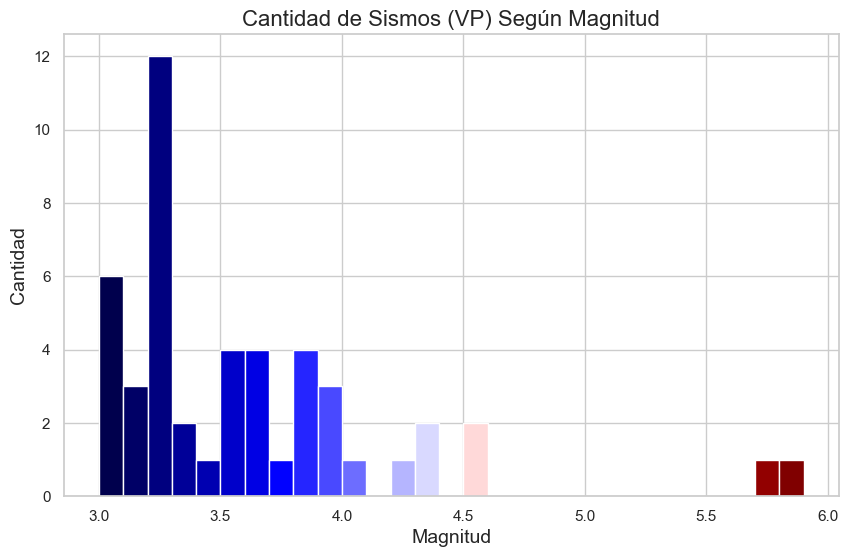

In [54]:

# Extraer las magnitudes
magnitudes_list = list(magnitudes.values())

# Crear los bins para el histograma
bins = np.arange(min(magnitudes_list), max(magnitudes_list) + 0.1, 0.1)

# Crear una función de color que va de azul (magnitudes bajas) a rojo (magnitudes altas)
#cmap = cm.get_cmap('coolwarm')
cmap = cm.get_cmap('seismic')


# Graficar el histograma
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(magnitudes_list, bins=bins)

# Cambiar el color de cada barra según su bin
for i in range(len(patches)):
    color_val = float(i)/(len(patches)-1)
    patches[i].set_facecolor(cmap(color_val))

plt.xlabel('Magnitud', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.title('Cantidad de Sismos (VP) Según Magnitud', fontsize=16)
plt.show()



In [55]:
files_bhz = find_files('señales_sismos\BHZ', ['.mseed'])
files_bhz_ch, key_names_bhz = sort_files(files_bhz, '.mseed')

files_24hrs = find_files('24hrs', ['.mseed'])
files_24hrs_ch, key_names_24hrs = sort_files(files_24hrs, '.mseed')

In [56]:
#estación principal CO10
main_st = files_bhz_ch[key_names_bhz[3]]
st_main = read(main_st[0])
st_main += read(main_st[1])
st_main += read(main_st[2])
st_main.filter('bandpass', freqmin=4.0, freqmax=10.0, corners=1, zerophase=True) 
print(st_main.select(channel='BHZ'))

#estación adyacente 1: AC04
adj_st_1 = files_bhz_ch[key_names_bhz[0]]
st_adj_1 = read(adj_st_1[0])
st_adj_1 += read(adj_st_1[1])
st_adj_1 += read(adj_st_1[2])
st_adj_1.filter('bandpass', freqmin=4.0, freqmax=10.0, corners=1, zerophase=True)
print(st_adj_1.select(channel='BHZ'))

#estación adyacente 2: AC05
adj_st_2 = files_bhz_ch[key_names_bhz[1]]
st_adj_2 = read(adj_st_2[0])
st_adj_2 += read(adj_st_2[1])
st_adj_2 += read(adj_st_2[2])
st_adj_2.filter('bandpass', freqmin=4.0, freqmax=10.0, corners=1, zerophase=True)
print(st_adj_2.select(channel='BHZ'))

#estación adyacente 3: CO05
adj_st_3 = files_bhz_ch[key_names_bhz[2]]
st_adj_3 = read(adj_st_3[0])
st_adj_3 += read(adj_st_3[1])
st_adj_3 += read(adj_st_3[2])
st_adj_3.filter('bandpass', freqmin=4.0, freqmax=10.0, corners=1, zerophase=True)
print(st_adj_3.select(channel='BHZ'))

1 Trace(s) in Stream:
C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
1 Trace(s) in Stream:
C1.AC04..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
1 Trace(s) in Stream:
C1.AC05..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
1 Trace(s) in Stream:
C1.CO05..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples


# Visualización de trazas problemáticas

### Se selecciona el canal deseado

In [57]:
#selecciona el canal BHZ de la estación principal
st_main_BHZ = st_main.select(channel='BHZ')
#selecciona el canal BHZ de la estación adyacente 1
st_adj_1_BHZ = st_adj_1.select(channel='BHZ')
#selecciona el canal BHZ de la estación adyacente 2
st_adj_2_BHZ = st_adj_2.select(channel='BHZ')
#selecciona el canal BHZ de la estación adyacente 3
st_adj_3_BHZ = st_adj_3.select(channel='BHZ')

### Se selecciona el tiempo deseado en los eventos

In [58]:
# Para ver un falso posivito consideramos el tiempo de partida del primer falso positivo de la lista
start_time_fp = UTCDateTime(f_positivos[0] - timedelta(seconds=20))
end_time_fp = UTCDateTime(f_positivos[0] + timedelta(seconds=20))

# Para ver un verdadero positivo consideramos el tiempo de partida del primer verdadero positivo de la lista
start_time_cp = UTCDateTime(v_positivos[0] - timedelta(seconds=20))
end_time_cp = UTCDateTime(v_positivos[0] + timedelta(seconds=20))
# 
# Para ver un falso negativo consideramos el tiempo de partida del primer falso negativo de la lista
start_time_fn = UTCDateTime(f_negativos[0] - timedelta(seconds=20))
end_time_fn = UTCDateTime(f_negativos[0] + timedelta(seconds=20))

### Tomamos las trazas que corresponden al primer encuentro con algun FP, TP Y FN 

In [59]:
# Se toma la parte de la traza que pertenece al falso positivo para cada estación
st_main_BHZ_fp = st_main_BHZ.slice(start_time_fp, end_time_fp)
st_adj_1_BHZ_fp = st_adj_1_BHZ.slice(start_time_fp, end_time_fp)
st_adj_2_BHZ_fp = st_adj_2_BHZ.slice(start_time_fp, end_time_fp)
st_adj_3_BHZ_fp = st_adj_3_BHZ.slice(start_time_fp, end_time_fp)


# Se toma la parte de la traza que pertenece al verdadero positivo para cada estación
st_main_BHZ_vp = st_main_BHZ.slice(start_time_cp, end_time_cp)
st_adj_1_BHZ_vp = st_adj_1_BHZ.slice(start_time_cp, end_time_cp)
st_adj_2_BHZ_vp = st_adj_2_BHZ.slice(start_time_cp, end_time_cp)
st_adj_3_BHZ_vp = st_adj_3_BHZ.slice(start_time_cp, end_time_cp)

# Se toma la parte de la traza que pertenece al falso negativo para cada estación
st_main_BHZ_fn = st_main_BHZ.slice(start_time_fn, end_time_fn)
st_adj_1_BHZ_fn = st_adj_1_BHZ.slice(start_time_fn, end_time_fn)
st_adj_2_BHZ_fn = st_adj_2_BHZ.slice(start_time_fn, end_time_fn)
st_adj_3_BHZ_fn = st_adj_3_BHZ.slice(start_time_fn, end_time_fn)



#### Ver falsos positivos

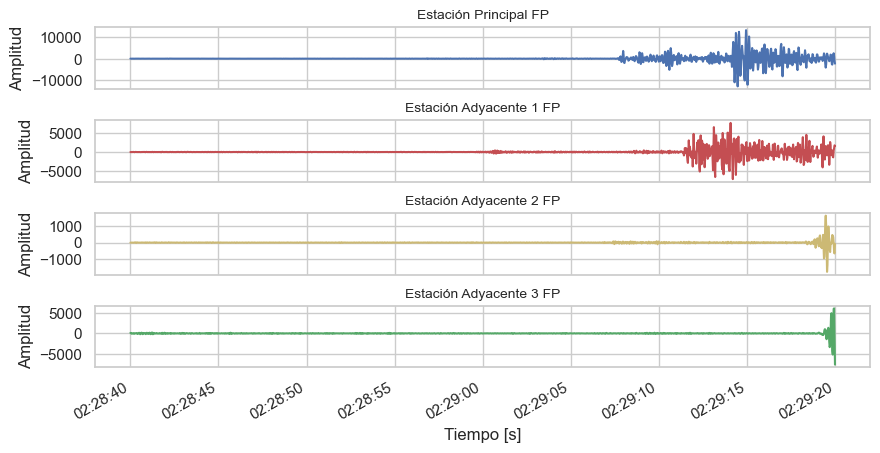

In [60]:
#Plot de la traza con falso positivo usando matplotlib 

fig, axs = plt.subplots(4,1, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5)

axs[0].plot(st_main_BHZ_fp[0].times("matplotlib"), st_main_BHZ_fp[0].data, '-b')
axs[0].set_title('Estación Principal FP', size=10)
axs[0].set_ylabel('Amplitud')
axs[0].xaxis_date()

axs[1].plot(st_adj_1_BHZ_fp[0].times("matplotlib"), st_adj_1_BHZ_fp[0].data, '-r')
axs[1].set_title('Estación Adyacente 1 FP', size=10)
axs[1].set_ylabel('Amplitud')
axs[1].xaxis_date()

axs[2].plot(st_adj_2_BHZ_fp[0].times("matplotlib"), st_adj_2_BHZ_fp[0].data, '-y')
axs[2].set_title('Estación Adyacente 2 FP', size=10)
axs[2].set_ylabel('Amplitud')
axs[2].xaxis_date()

axs[3].plot(st_adj_3_BHZ_fp[0].times("matplotlib"), st_adj_3_BHZ_fp[0].data, '-g')
axs[3].set_title('Estación Adyacente 3 FP', size=10)
axs[3].set_ylabel('Amplitud')
axs[3].set_xlabel('Tiempo [s]')
axs[3].xaxis_date()

fig.autofmt_xdate()
plt.show()


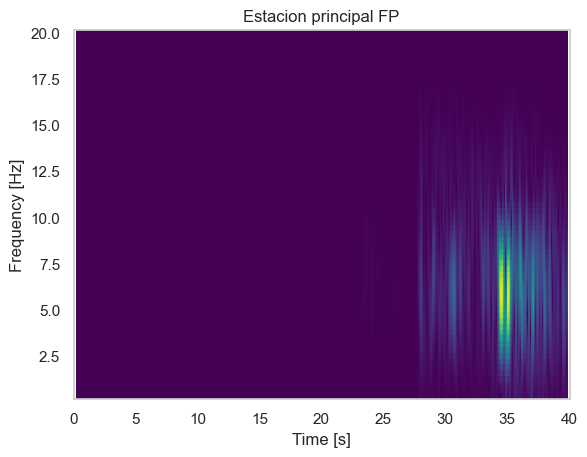

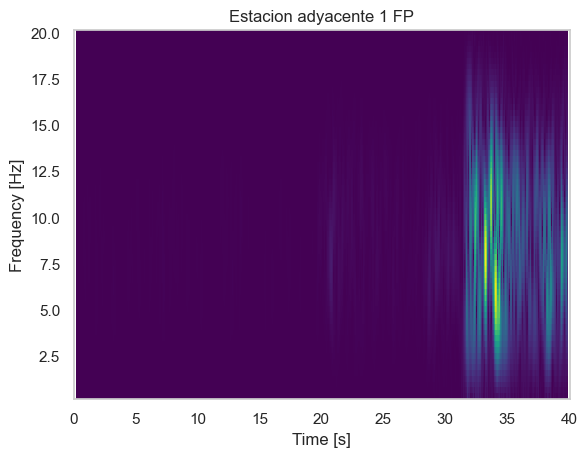

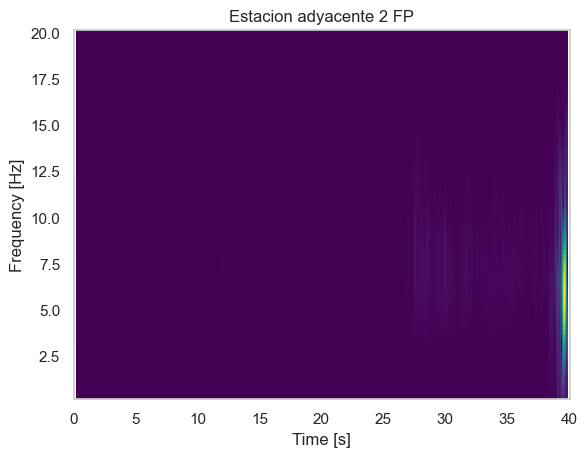

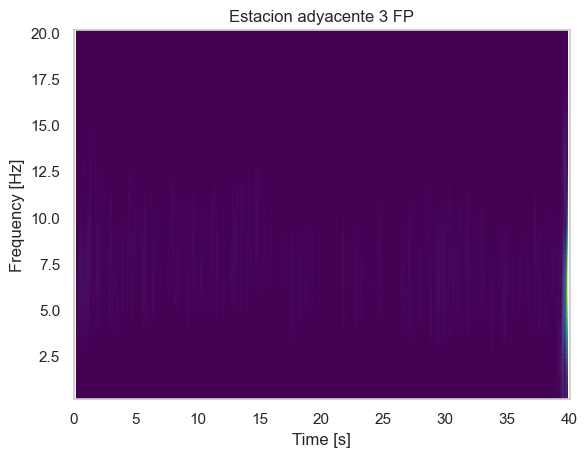

[None]

In [61]:
# Se plotea el espectrograma de cada estación de la traza con falso positivo
st_main_BHZ_fp.spectrogram(title = 'Estacion principal FP')
st_adj_1_BHZ_fp.spectrogram(title = "Estacion adyacente 1 FP")
st_adj_2_BHZ_fp.spectrogram(title = "Estacion adyacente 2 FP")
st_adj_3_BHZ_fp.spectrogram(title = "Estacion adyacente 3 FP")


#### Ver falsos negativos

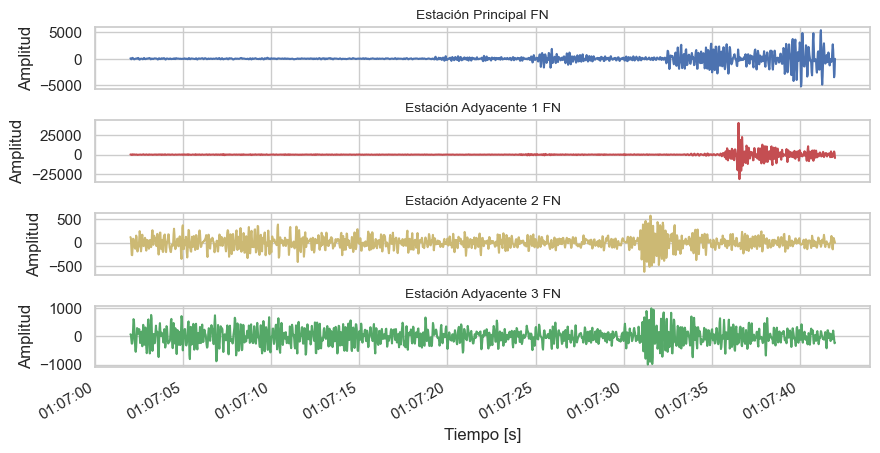

In [62]:
#Plot de la traza con falso negativos usando matplotlib 

fig, axs = plt.subplots(4,1, figsize=(10, 5)) 
fig.subplots_adjust(hspace=0.5)


axs[0].plot(st_main_BHZ_fn[0].times("matplotlib"), st_main_BHZ_fn[0].data, '-b')
axs[0].set_title('Estación Principal FN', size=10)
axs[0].set_ylabel('Amplitud')
axs[0].xaxis_date()

axs[1].plot(st_adj_1_BHZ_fn[0].times("matplotlib"), st_adj_1_BHZ_fn[0].data, '-r')
axs[1].set_title('Estación Adyacente 1 FN', size=10)
axs[1].set_ylabel('Amplitud')
axs[1].xaxis_date()

axs[2].plot(st_adj_2_BHZ_fn[0].times("matplotlib"), st_adj_2_BHZ_fn[0].data, '-y')
axs[2].set_title('Estación Adyacente 2 FN', size=10)
axs[2].set_ylabel('Amplitud')
axs[2].xaxis_date()

axs[3].plot(st_adj_3_BHZ_fn[0].times("matplotlib"), st_adj_3_BHZ_fn[0].data, '-g')
axs[3].set_title('Estación Adyacente 3 FN', size=10)
axs[3].set_ylabel('Amplitud')
axs[3].set_xlabel('Tiempo [s]')
axs[3].xaxis_date()

fig.autofmt_xdate()
plt.show()

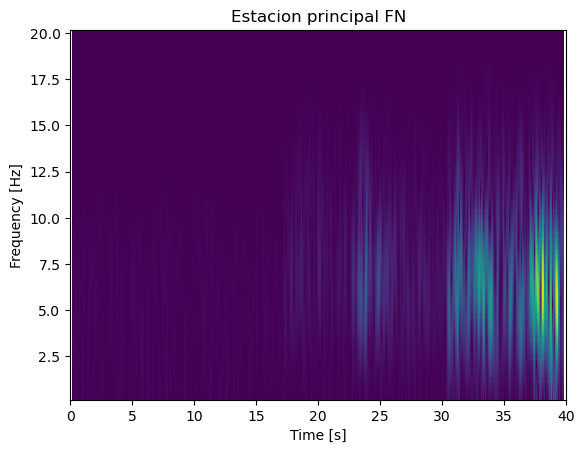

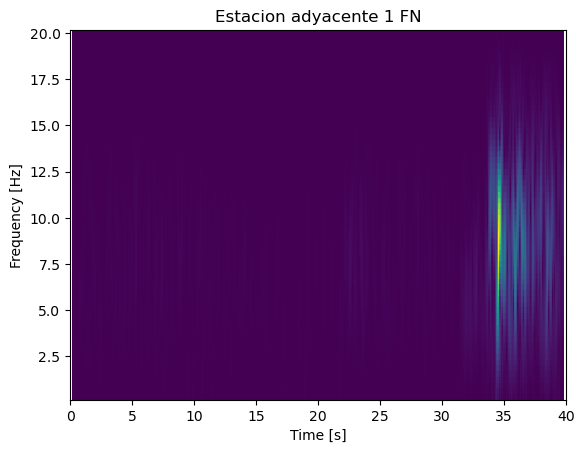

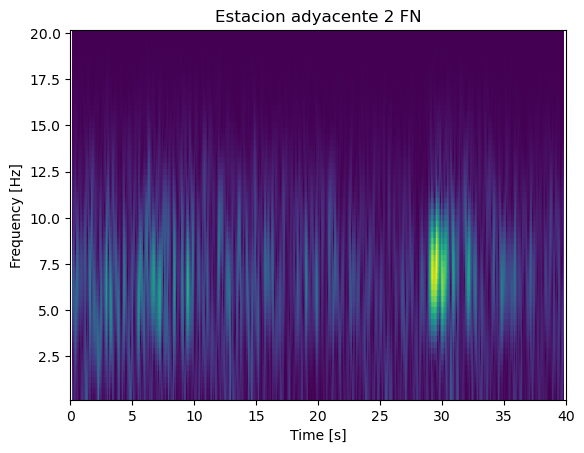

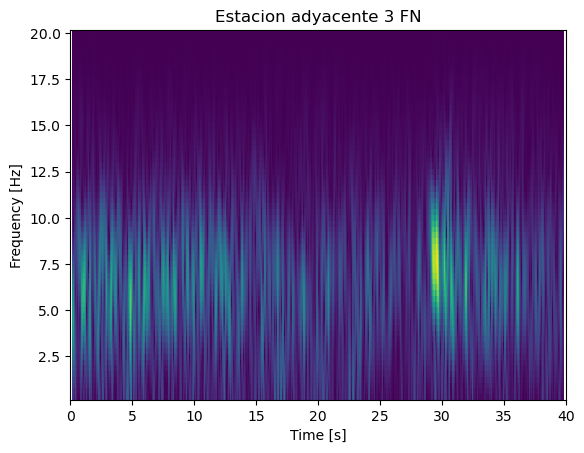

[None]

In [28]:
# Se plotea el espectrograma de cada estación de la traza con falso negativo
st_main_BHZ_fn.spectrogram(title = 'Estacion principal FN')
st_adj_1_BHZ_fn.spectrogram(title = "Estacion adyacente 1 FN")
st_adj_2_BHZ_fn.spectrogram(title = "Estacion adyacente 2 FN")
st_adj_3_BHZ_fn.spectrogram(title = "Estacion adyacente 3 FN")

#### Ver verdaderos positivos

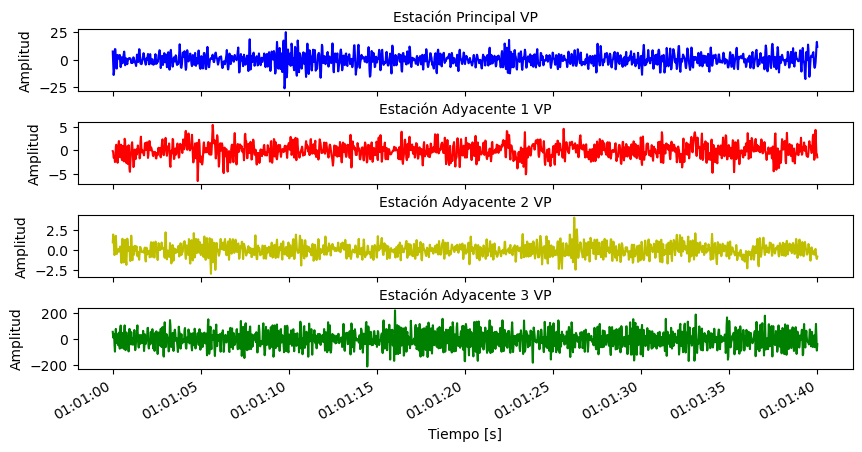

In [29]:
#Plot de la traza con verdaderos positivos usando matplotlib 

fig, axs = plt.subplots(4,1, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5)

axs[0].plot(st_main_BHZ_vp[0].times("matplotlib"), st_main_BHZ_vp[0].data, '-b')
axs[0].set_title('Estación Principal VP', size=10)
axs[0].set_ylabel('Amplitud')
axs[0].xaxis_date()

axs[1].plot(st_adj_1_BHZ_vp[0].times("matplotlib"), st_adj_1_BHZ_vp[0].data, '-r')
axs[1].set_title('Estación Adyacente 1 VP', size=10)
axs[1].set_ylabel('Amplitud')
axs[1].xaxis_date()

axs[2].plot(st_adj_2_BHZ_vp[0].times("matplotlib"), st_adj_2_BHZ_vp[0].data, '-y')
axs[2].set_title('Estación Adyacente 2 VP', size=10)
axs[2].set_ylabel('Amplitud')
axs[2].xaxis_date()

axs[3].plot(st_adj_3_BHZ_vp[0].times("matplotlib"), st_adj_3_BHZ_vp[0].data, '-g')
axs[3].set_title('Estación Adyacente 3 VP', size=10)
axs[3].set_ylabel('Amplitud')
axs[3].set_xlabel('Tiempo [s]')
axs[3].xaxis_date()

fig.autofmt_xdate()
plt.show()

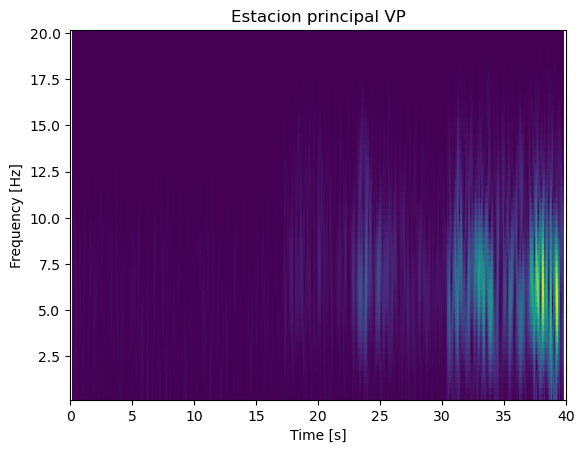

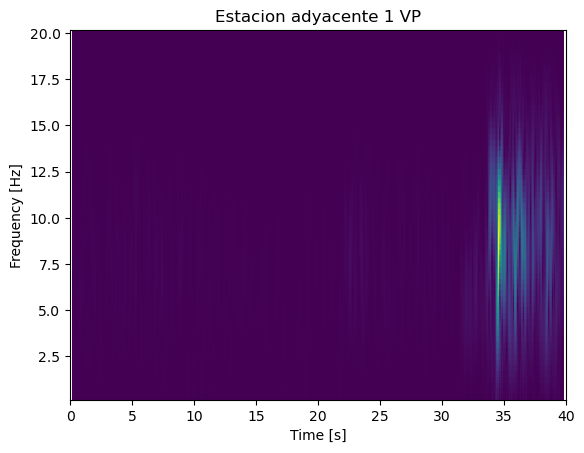

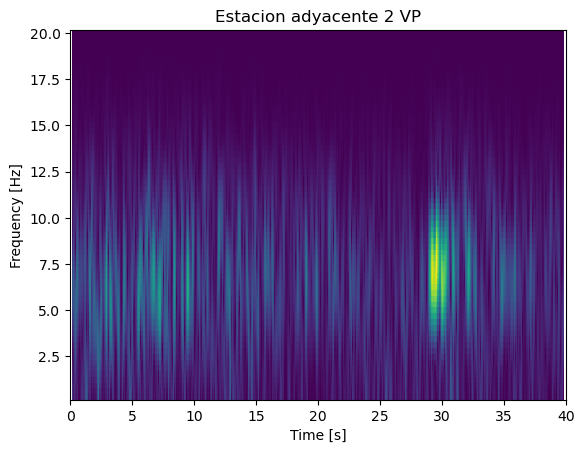

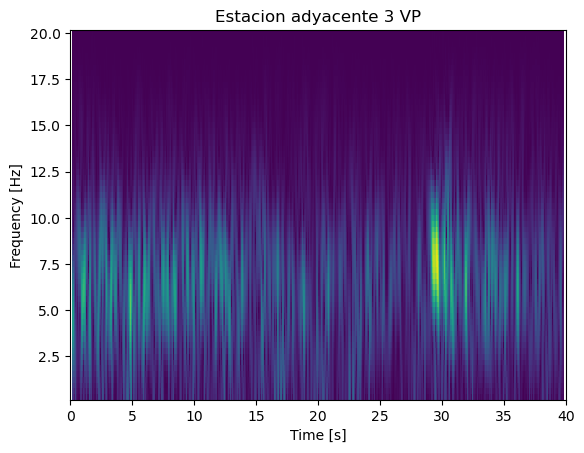

[None]

In [30]:
# Se plotea el espectrograma de cada estación de la traza con verdadero positivo
st_main_BHZ_fn.spectrogram(title = 'Estacion principal VP')
st_adj_1_BHZ_fn.spectrogram(title = "Estacion adyacente 1 VP")
st_adj_2_BHZ_fn.spectrogram(title = "Estacion adyacente 2 VP")
st_adj_3_BHZ_fn.spectrogram(title = "Estacion adyacente 3 VP")